In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from scipy.signal import lfilter
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import  plotly.graph_objects as go
import pandas as pd
from src.passband_modulations  import bpsk_mod,bpsk_demod
from src.channels import awgn
from src.essentials import plotWelchPSD 
from scipy.special import erfc

In [5]:
def DEBPSK_performance():

    N = 10000 # Number of symbols to transmit
    EbN0dB = np.arange(-4,11,2) # Eb/N0 range in dB for simulation
    L = 16 # Oversampling factor, L = Tb/Ts (Tb = bit period, Ts = sampling period)
    # If a carrier is used, use L = Fs/Fc, where Fs >> 2*Fc
    Fc = 800 # Carrier frequency
    Fs = L*Fc # Sampling frequency
    SER = np.zeros(len(EbN0dB)) # For SER values for each EbN0

    ak = np.random.randint(2, size = N) # Uniform random symbols from 0s and 1s
    bk = lfilter([1.0], [1.0,-1.0], ak) # IIR filter for differential encoding
    bk = bk % 2 # XOR operation is equivalent to modulo-2

    [s_bb,t] = bpsk_mod(bk,L) # BPSK modulation (waveform) - baseband
    s = s_bb*np.cos(2*np.pi*Fc*t/Fs) # DEBPSK with carrier

    for i, EbN0 in enumerate(EbN0dB):

        # Compute and add AWGN noise
        r = awgn(s,EbN0,L) # Refer to Chapter section 4.1

        phaseAmbiguity = np.pi # 180 degree phase ambiguity of Costas loop
        r_bb = r*np.cos(2*np.pi*Fc*t/Fs + phaseAmbiguity) # Recovered signal
        b_hat = bpsk_demod(r_bb, L) # Baseband correlation type demodulator
        a_hat = lfilter([1.0,1.0], [1.0], b_hat) # FIR for differential decoding
        a_hat = a_hat % 2 # Binary messages, therefor modulo-2
        SER[i] = np.sum(ak != a_hat)/N # Symbol error rate computation

    #------Theoretical Bit/Symbol Error Rates------
    EbN0lins = 10**(EbN0dB/10) # Converting dB values to linear scale
    theorySER_DPSK = erfc(np.sqrt(EbN0lins))*(1-.5*erfc(np.sqrt(EbN0lins)))
    theorySER_BPSK = .5*erfc(np.sqrt(EbN0lins))

    #------Plots------
    plt.figure(0)
    plt.semilogy(EbN0dB,SER,'k*',label='Coherent DEBPSK(sim)')
    plt.semilogy(EbN0dB,theorySER_DPSK,'r-',label='Coherent DEBPSK(theory)')
    plt.semilogy(EbN0dB,theorySER_BPSK,'b-',label='Conventional BPSK')
    plt.xlabel('$E_b/N_0$ (dB)')
    plt.ylabel('Probability of Bit Error - $P_b$')
    plt.title('Probability of Bit Error for DEBPSK and BPSK over AWGN')
    plt.grid()
    plt.legend()
    #plt.savefig('Ch2_images/DEBPSK_performance.png')

<h1 style="text-align: center;"> Transmissão DBPSK </h1>

<h3 style="text-align: center;">Disciplina: Comunicações Digitais para Engenaharia</h3>


<p style="text-align: center;">Prof. Daniel C. Araújo</p>

# Modulador 

> Uso de um codificador diferencial  

$$
b[k] = b[k-1] \oplus  a[k]
$$

> Neste caso, a fase é configurada pela diferença de fase entre dois símbolos consecutivos.

  * O objetivo é resolver a ambiguidade de fase que podem ocorrer devido a mecanismos de sincronização.

<img src="Figs/mod_digi/dbpsk_tx.png" alt="isolated"/>

# Demodulador

<img src="Figs/mod_digi/dbpsk_rx.png" alt="isolated"/>

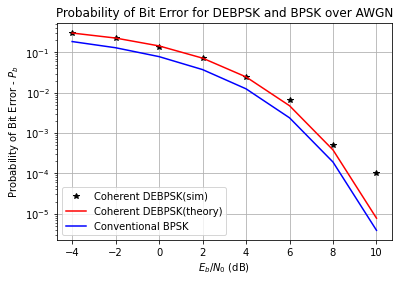

In [6]:
desemempenho_dbpsk = DEBPSK_performance()

## Arquitetura sub-ótima para receptores não coerentes

* Presença de filtor IF para redução do ruído e preservação da fase entre os símbolos
*  Na saída do integrador
  $$
  z = \int _{-kT_b}^{(k+1)T_b} r(t)r(t-T_b)dt
  $$
* Na ausência de ruído tem-se que: 
  $$z = \int _{-kT_b}^{(k+1)T_b} s_k(t)s_{k-1}(t-T_b)dt =
  \begin{cases}
  E_b&   s_k(t) = s_{k-1}(t) \\
  -E_b&   s_k(t) = -s_{k-1} (t)
  \end{cases}
  $$
<img src="Figs/mod_digi/debpsk_subopt.png" alt="isolated"/>

## Arquitetura ótima para moduladores não coerentes



<img src="Figs/mod_digi/dbpsk_opt.png" alt="isolated"/>

In [12]:
def DBPSK_noncoherent():

 

    N = 100000 # Number of symbols to transmit
    EbN0dB = np.arange(-4,11,2) # Eb/N0 range in dB for simulation
    L = 8 # Oversampling factor L = Tb/Ts
    # If carrier is used, use L = Fs/Fc where Fs >> 2*Fc
    Fc = 800 # Carrier frequency
    Fs = L*Fc # Sampling frequency

    BER_suboptimum = np.zeros(len(EbN0dB)) # BER measures
    BER_optimum = np.zeros(len(EbN0dB))

    #--------Transmitter--------
    ak = np.random.randint(2, size=N) # Uniform random symbols from 0s and 1s
    bk = lfilter([1.0],[1.0,-1.0],ak) # IIR filter for differential encoding
    bk = bk % 2 # XOR operation is equivalent to modulo-2
    [s_bb,t] = bpsk_mod(bk,L) # BPSK modulation (waveform) - baseband
    s = s_bb*np.cos(2*np.pi*Fc*t/Fs).astype(complex) # DBPSK with carrier

    for i,EbN0 in enumerate(EbN0dB):

        # Compute and add AWGN noise
        r = awgn(s,EbN0,L) # Refer to Chapter section 4.1

        #--------Suboptimum receiver--------
        p = np.real(r)*np.cos(2*np.pi*Fc*t/Fs) # Demodulate to baseband using BPF
        w0 = np.hstack((p,np.zeros(L))) # Append L samples on one arm for equal lengths
        w1 = np.hstack((np.zeros(L),p)) # Delay the other arm by Tb (L samples)
        w = w0*w1 # Multiplier
        z = np.convolve(w, np.ones(L)) # Integrator from kTb to (k+1)Tb (L samples)
        u = z[L-1:-1-L:L] # Sampler t = kTb
        ak_hat = (u<0) # Decicion
        BER_suboptimum[i] = np.sum(ak != ak_hat)/N # BER for suboptimum receiver

        #--------Optimum receiver--------
        p = np.real(r)*np.cos(2*np.pi*Fc*t/Fs) # Multiply I arm by cos
        q = np.imag(r)*np.sin(2*np.pi*Fc*t/Fs) # Multiply Q arm by sin
        x = np.convolve(p, np.ones(L)) # Integrate I-arm by Tb duration (L samples)
        y = np.convolve(q, np.ones(L)) # Integrate Q-arm by Tb duration (L samples)
        xk = x[L-1:-1:L] # Sample every Lth sample
        yk = y[L-1:-1:L] # Sample every Lth sample
        w0 = xk[0:-2] # Non-delayed version on I-arm
        w1 = xk[1:-1] # 1-bit delay on I-arm
        z0 = yk[0:-2] # Non-delayed version on Q-arm
        z1 = yk[1:-1] # Non-delayed version on Q-arm
        u = w0*w1 + z0*z1 # Decision statistic
        ak_hat = (u<0) # Threshold detection
        BER_optimum[i] = np.sum(ak[1:-1] != ak_hat)/N # BER for optimum receiver

    #--------Theoretical Bit/Symbol Error Rates--------
    EbN0lins = 10**(EbN0dB/10) # Convert dB to linear
    theory_DBPSK_optimum = .5*np.exp(-EbN0lins)
    theory_DBPSK_suboptimum = .5*np.exp(-.76*EbN0lins)
    theory_DBPSK_coherent = erfc(np.sqrt(EbN0lins))*(1-.5*erfc(np.sqrt(EbN0lins)))
    theory_BPSK_conventional = .5*erfc(np.sqrt(EbN0lins))

    #------Plots------
    plt.figure(0)
    plt.semilogy(EbN0dB, BER_suboptimum, 'k*', label = 'DBPSK subopt (sim)')
    plt.semilogy(EbN0dB, BER_optimum, 'b*', label = 'DBPSK opt (sim)')
    plt.semilogy(EbN0dB, theory_DBPSK_suboptimum, 'm-', label = 'DBPSK subopt (theory)')
    plt.semilogy(EbN0dB, theory_DBPSK_optimum, 'r-', label = 'DBPSK opt (theory)')
    plt.semilogy(EbN0dB, theory_DBPSK_coherent, 'k-', label = 'Coherent DEBPSK')
    plt.semilogy(EbN0dB, theory_BPSK_conventional, 'b-', label = 'Coherent BPSK')
    plt.xlabel('$E_b/N_0 (dB)$')
    plt.ylabel('$Probability of Bit Error - P_b$')
    plt.title('Probability of D-BPSK over AWGN')
    plt.grid()
    plt.legend()


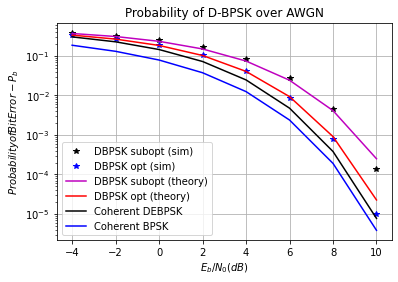

In [13]:
simulation = DBPSK_noncoherent()

In [4]:
import numpy as np
num = np.array([0,1,2,3,4,5])

In [5]:
np.random.permutation(num)

array([0, 1, 5, 2, 3, 4])

In [6]:
np.random.permutation([1,2])

array([2, 1])